# PROJECT: ANALYZING NYC HIGH SCHOOL DATA

The SAT (Scholastic Aptitude Test) is a standardized test high school seniors in the United States take every year, which serves as an assessment and decision aid by colleges for admissions. 

The SAT is comprised of three sections, amounting to a total maximum score of 2400 points. 

Being one of the most significant factor during college admissions, the effectiveness and fairness of the SATs has come under scrutiny by many stakeholders and beyond, on the unfair advantage it offers to students with more priviledged backgrounds.

New York City, constitutes of a very diverse immigrant population with different demographic factors specifically nationality, race and gender. 


The aim of this project is to analyze the data on the SAT scores of High school students across New York City from the [NYC Open Data](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4), along with additional data sets, including [Attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt), [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3), [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e),[Graduation Outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) [Demograhics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j),  [School Survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) to determine the fairness of the SAT tests.

# 1.  PREPARING THE DATA.

** The following steps will focus on preparing the data, including reading the data into the appropriate data structures, adding the DBN Columns (unique identifier for high schools), converting values to numeric and condensing the data **

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

#  Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

Correlations inform us of how closely related variables are. The Pearson's correlation coefficient which measures the linear correlation between two variables will be used to determine what features in the data sets strongly or weakly correlate with the SAT Score. The r value ranges from -1 to +1, where correlations closer to -1 indicate a strong negative correlation, +1 indicates a strong positive correlation and correlations close to 0 indicates a weak correlation.

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

The above results computed the correlations between the SAT Score and all features in the combined datasets. With a quick glance, we can see that features such as the SAT Writing, Math and Reading Scores strongly correlate with the SAT Score. Similalry AP tests does have a positive correlation, which may indicate that students who take the AP Exam are more likely to do well in the SATS. On the contrary, features such as fr_1 percent have a negative correlation.

However, due to the large amount of features we are unable to extract valuable information on the correlations. Thus, the next sections will focus on plotting the correlations to the SAT Score  for each dataset.

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

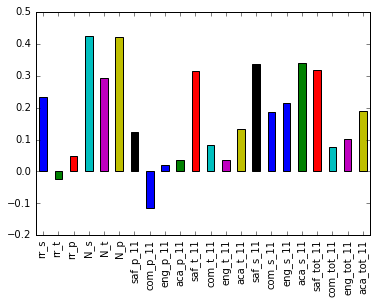

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

N_s, N_t, N_p which stands for Number of students repsondents, Number of teachers respondents, and Number of parents resposedents indicate a positive correlation. 

the aca_s_11 column which represents the Academic expectation score based on students repsonse, has a positive correlation withe the SAT Score. This may indicate that how student percieve the academic standards of their school correlates with their SAT Score.

Additionally, two interesting columns saf_t_11 and saf_s_11 which measures how teachers and students percieve the level of safety at school had a high postive correlation with sat_score. This could mean schools with higher level of safety in the school, performed better at the SAT exams, while schools where students and teachers feel less safe, performed less.

The next section focuses on understanding if safety is a contributing factor to performance in the SAT.

## Perception of School Safety and SAT Scores.

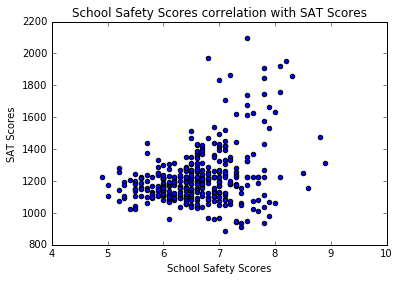

In [12]:
import matplotlib.pyplot as plt
plt.scatter(x=combined["saf_s_11"], y=combined["sat_score"])
plt.xlabel("School Safety Scores")
plt.ylabel("SAT Scores")
plt.title("School Safety Scores correlation with SAT Scores")
plt.show()

The scatter plot above maps a correlation between the SAT Score and the Safety Scores reported from students. Overall, there is a positive linear relationship, but the correlation is not very strong, with a large cluster around the safety score 5 to 7. 

Students who percieved the level of safety within the range of 5 to 7 out of a 10, scored between 1000 to 1500 in their SATs. Additionally, safety scores between 7 to 8.5 had both high and low SAT Scores. Thus, there is not much insight earned by individually analyzing each schools safety score with their SAT Score.

However, we can analyze the correlation between the safety scores of the boroughs of New York City with the average SAT Scores of the schools in each district.

To explore the relationship between the safety of districts in New York City and the average SAT scores, we will map out both the safety scores and SAT Scores by district. The map will show us which areas of the city have a high SAT Score and high Safety Score or the opposite.

In [13]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,139.041709,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,97.597416,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,129.765099,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,100.118588,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240


In [14]:
districts.reset_index(inplace=True)

*** NYC BOROUGH MAP ***

The image map of New York City below serves as a context for those not familiar with the geopgraphical distribution in New York city.

In [15]:
%%html
<img src="https://yourfreetemplates.com/wp-content/uploads/2017/10/New_York_City_Borough_Map-e1507453244673.png" />

*** MAPPING SAFETY SCORES AND SAT SCORES FOR EACH BOROUGH ***

The following maps will convert the sequence of numbers i.e the Safety Scores for the first map, and the SAT scores for the second map to values ranging from 0 to 1. It will then map these values onto a colormap. 

The color map being used is the "summer colormap", where;
Yellow points = High
Green points = Low 

Thus, boroughs with high safety scores will be represented with yellow points, and those with low safety scores will be represented with green points.

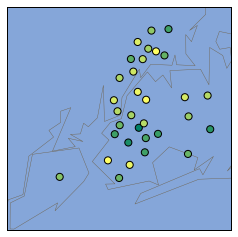

In [16]:
from mpl_toolkits.basemap import Basemap
newyork_map = Basemap (
    projection = "merc",
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution = "i"
)
newyork_map.drawmapboundary(fill_color='#85A6D9')
newyork_map.drawcoastlines(color='#6D5F47', linewidth=.4)
newyork_map.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
newyork_map.scatter(longitudes,latitudes, s=50, zorder=2,latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

Upper Manhattan, some parts of Bronx and Queens have high safety scores. Whereas, Brooklyn has a lot of low safety scores.

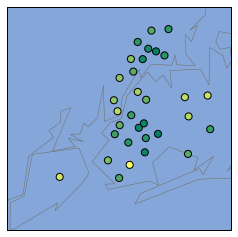

In [17]:
from mpl_toolkits.basemap import Basemap
newyork_map = Basemap (
    projection = "merc",
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution = "i"
)
newyork_map.drawmapboundary(fill_color='#85A6D9')
newyork_map.drawcoastlines(color='#6D5F47', linewidth=.4)
newyork_map.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
newyork_map.scatter(longitudes,latitudes, s=50, zorder=2,latlon=True, c=districts["sat_score"], cmap="summer")
plt.show()

Regarding the SAT scores, Brooklyn does indeed has a lot of low SAT Scores. Queens and Manhattan seem to have higher average SAT Scores. However, Bronx which had some high safety scores, does not do so for the SAT Scores. 

Thus, the Safety Scores assigned by students might not be a great correlation for the SAT Scores earned.

## Racial differences in SAT Scores

This section focuses on plotting any correlation between the SAT Scores and racial demographic, to determine if racial difference has an influence in SAT performance

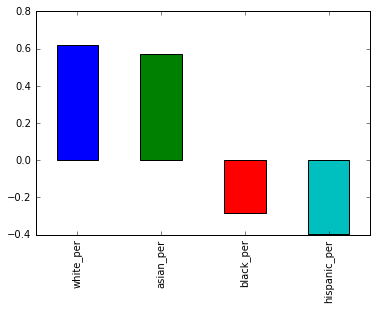

In [18]:
%matplotlib inline
races = ["white_per","asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][races].plot.bar()

Based on the diagram above, there is a positive correlation between SAT Scores and students that are white or asian. Whereas, a high percentage of hispanic and black students score negatively correlates with the SAT Scores. 

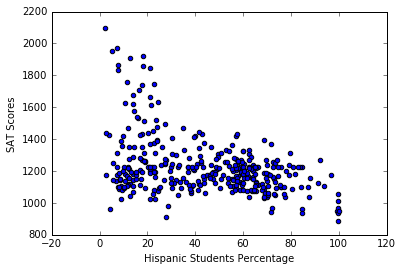

In [19]:
plt.scatter(x=combined["hispanic_per"], y=combined["sat_score"])
plt.xlabel("Hispanic Students Percentage")
plt.ylabel("SAT Scores")
plt.show()

The scatter plot above, has a weak linear relationship between the percentage of Hispanic students and the SAT Scores of the schools. Overall most of the schools did not have high SAT Scores. 

However, schools with lower percentage of hispanic students (between 0 to 20%), recoreded some very high SAT Scores, while the schools that had 100% hispanic students all had very low SAT Scores. The following are the list of those schools with 95% and above hispanic students.

In [20]:
hispanic_95schools = combined[combined["hispanic_per"] > 95]
hispanic_95schools["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Upon conducting a research on these schools, the schools are geared towards recent immigrants to the United States. A lot of students studying in these schools are still intensively learning English, which could be a contributing factor to the lower SAT Scores.

In [21]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Inversely, a research conducted on the schools with low percentage of hispanic students but high SAT Scores appears to be specialized in science and technology, have strict entrance procedures and recieve sufficient funding. 

## Gender differences in SAT Scores

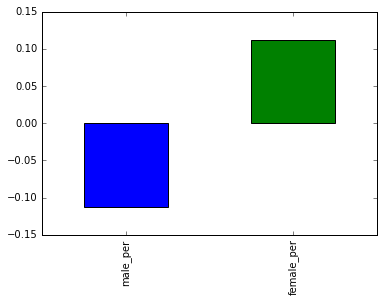

In [22]:
%matplotlib inline
gender_per = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_per].plot.bar()

The bar plot above indicates that a positive correlation between the percentage of females and the SAT Scores, and a negative correlation between the percentage of males and SAT Scores. However, the correlations rane between 0.00 to ( + 0.15 and -
0.15), making them weak.

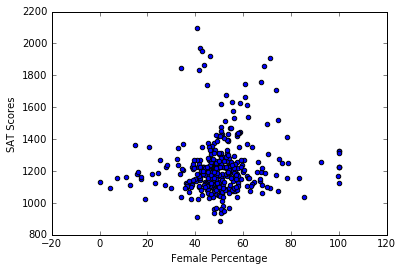

In [23]:
plt.scatter(x=combined["female_per"], y=combined["sat_score"])
plt.xlabel("Female Percentage")
plt.ylabel("SAT Scores")
plt.show()

The scatter plot above does indeed proves that there is no real correlation between the percentage of females in a school and their SAT Performance. However, a cluster of schools with 40% to 60% of females have high SAT Scores ranging from 1800 - 2200.

The schools that match this threshold are listed below.

In [24]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


A quick research on these schools indicated that they are highly selective schools with high academic standards. This could indicate that having a large female population does not serve as the reason for their high average SAT scores, rather due their standards of admitting bright students in the first place, while placing them on rigorous on a rigorous curicullum. 

## AP Scores and SAT Scores.

In [25]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations.iloc[[4]]

AP Test Takers     0.52314
Name: sat_score, dtype: float64

AP exams are Advanced Placement exams that gives students the opportunity to earn college credit for numerous subjects. Typically students take AP classes then sit for the exams. The advantage of taking an AP is that it prepares students for college work, boosts their college application an earns them credir. However, schools in rural areas are less likely to offer AP courses.

The above code indicates that the correlation between sat_score with the students that took an AP test is 0.5, which is a relatively high correlation. 

This section focuses on looking at the percentage of students enrolled that took at least one AP exam and their SAT Score, to verify if AP exams really does make a difference.

In [26]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

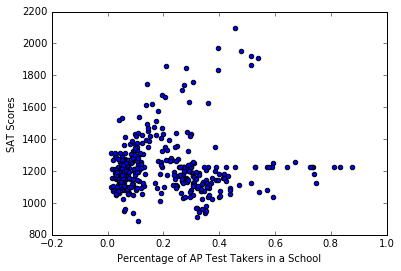

In [27]:
plt.scatter(x=combined["ap_per"], y=combined["sat_score"])
plt.xlabel("Percentage of AP Test Takers in a School")
plt.ylabel("SAT Scores")
plt.show()

A correlation definitely exists between AP test takers and the SAT score, however the correlation is not very strong. 

As seen above, schools that had above 80% of students taking at least one AP course performed relatively the same with schools that had less than 20% of their students taking an AP course. Similarly none of the schools with the above 80% AP Test takers performed high in their SAT exams.

This could mean that the feature that may determine if AP test has an effect on SAT, is the AP score of the students.

## Conclusion and Further Analysis

To summarize the insights gained during the analysis of High School Data of New York Schools:

* Students assigned safety perception of a school has not much influence in their performance in the SAT. We could not determine if the safety of the NYC boroughs says something regaring the SAT Scores, this is due how broad such an analysis is

* Schools with a high percentage of Hispanic and Black students performed lower in the SAT exams in comparison to schools with high percentage of White and Asian students whom performed higher, however as our analysis indicates the schools with large number of Hispanic students but low SAT scores, were schools geared towards recent immigrants with a focus on learning language.

* Gender has no influence in the SAT Scores.

*** FURTHER ANALYSIS ***

The following conclusions are far from being accurate as there are many missing nuances which leaves room for further analysis. Based on the insights above, potential questions and hypothesis raised includes;

1. Figuring out which neighborhoods have the best schools and highest SAT Scores, and correlating those neighborhoods with a dataset containing property values to conclude how the SAT scores of schools in expensive neighborhoods differ from their counterpart. And also to find the least expensive neighborhoods that have good schools.

2. Finding correlation between class size and SAT Scores.

3. Determinng if there is a correlation between AP Scores and SAT Scores.

4. Recording the differences between parent, teacher and students responses to surveys to realize any differences in perception. 

5. Ranking schools based on their SAT Scores and college destination of their students.



&copy; Khadija Lawal, 2020